In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [71]:
df = pd.read_csv("../data/dataset.csv", encoding="ISO-8859-1", low_memory=False)

In [72]:
# Convert Date to Datetime & Extract Features
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

In [73]:
# CPCB AQI Calculation using all major pollutants
def calculate_aqi(row):
    breakpoints = {
        'pm2_5': [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200), (91, 120, 201, 300), (121, 250, 301, 400)],
        'pm10': [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200), (251, 350, 201, 300), (351, 430, 301, 400)],
        'no2': [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200), (181, 280, 201, 300), (281, 400, 301, 400)],
        'so2': [(0, 40, 0, 50), (41, 80, 51, 100), (81, 380, 101, 200), (381, 800, 201, 300), (801, 1600, 301, 400)],
        'co': [(0, 1, 0, 50), (1.1, 2, 51, 100), (2.1, 10, 101, 200), (10.1, 17, 201, 300), (17.1, 34, 301, 400)],
        'o3': [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200), (169, 208, 201, 300), (209, 748, 301, 400)]
    }
    
    sub_indices = []
    for pollutant, bps in breakpoints.items():
        if pollutant in row:
            value = row[pollutant]
            for c_low, c_high, i_low, i_high in bps:
                if c_low <= value <= c_high:
                    sub_index = ((i_high - i_low) / (c_high - c_low)) * (value - c_low) + i_low
                    sub_indices.append(sub_index)
                    break
    
    return max(sub_indices) if sub_indices else np.nan
# Apply AQI calculation to dataset
df['AQI'] =df.apply(calculate_aqi, axis=1)

In [74]:
# Select Features & Target
features = ['year', 'month', 'day', 'day_of_week', 'is_weekend', 'so2', 'no2', 'pm2_5']
target = 'AQI'
X = df[features]
y = df['AQI']

In [75]:
# Handle missing values
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)
y = y.fillna(y.median())


In [76]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [77]:
# Train Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [60]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=5, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [78]:
# Predictions
y_pred = model.predict(X_test)

In [79]:
# Evaluate Model
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))

MAE: 0.09871639777882468
RMSE: 1.1618720530401703
R² Score: 0.9977635984627673


In [80]:
# Predict Future AQI (Example: Next Month)
future_dates = pd.DataFrame({'year': [2026]*30, 'month': [4]*30, 'day': np.arange(1, 31),
                             'day_of_week': np.arange(30) % 7, 'is_weekend': [1 if d % 7 >= 5 else 0 for d in range(30)],
                             'so2': 10, 'no2': 20, 'pm2_5': 50})


In [81]:
future_aqi = model.predict(future_dates)
future_dates['Predicted_AQI'] = future_aqi


c:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [82]:

# Show Future AQI Predictions
print(future_dates)


    year  month  day  day_of_week  is_weekend  so2  no2  pm2_5  Predicted_AQI
0   2026      4    1            0           0   10   20     50      83.103448
1   2026      4    2            1           0   10   20     50      83.103448
2   2026      4    3            2           0   10   20     50      83.103448
3   2026      4    4            3           0   10   20     50      83.103448
4   2026      4    5            4           0   10   20     50      83.103448
5   2026      4    6            5           1   10   20     50      83.103448
6   2026      4    7            6           1   10   20     50      83.103448
7   2026      4    8            0           0   10   20     50      83.103448
8   2026      4    9            1           0   10   20     50      83.103448
9   2026      4   10            2           0   10   20     50      83.103448
10  2026      4   11            3           0   10   20     50      83.103448
11  2026      4   12            4           0   10   20     50  

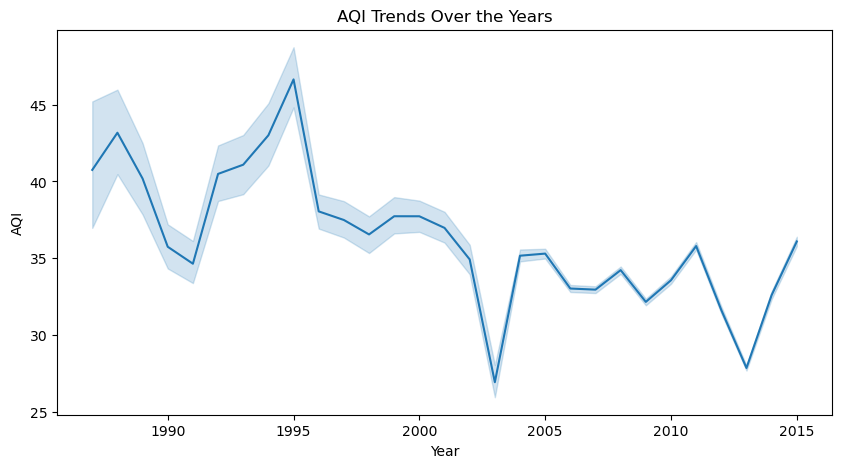

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.lineplot(x=df['year'], y=df['AQI'])
plt.title("AQI Trends Over the Years")
plt.xlabel("Year")
plt.ylabel("AQI")
plt.show()


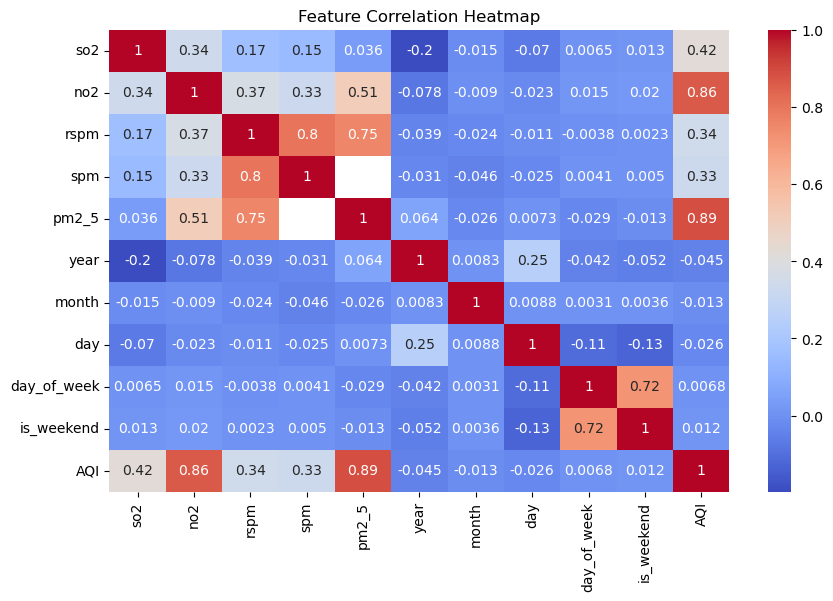

In [84]:
numeric_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()



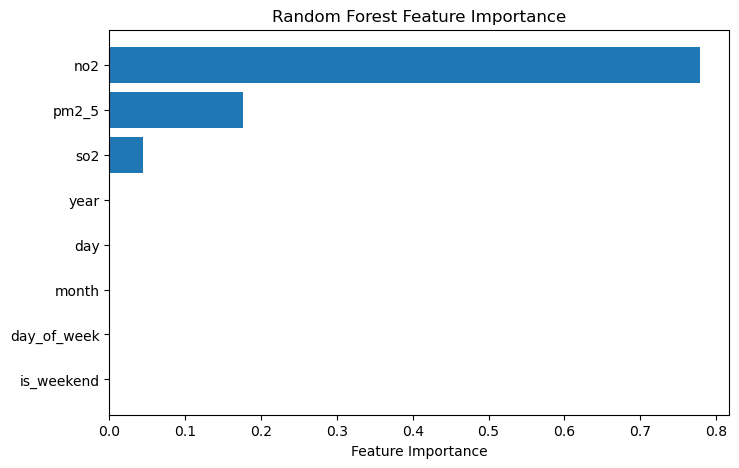

In [85]:

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(8, 5))
plt.barh(np.array(features)[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()


In [86]:
# Feature Importance
feature_importances = pd.DataFrame({'Feature': features, 'Importance': model.feature_importances_})
print(feature_importances.sort_values(by='Importance', ascending=False))

       Feature  Importance
6          no2    0.778821
7        pm2_5    0.175723
5          so2    0.043615
0         year    0.000866
2          day    0.000440
1        month    0.000305
3  day_of_week    0.000207
4   is_weekend    0.000023


In [89]:
import os
import pickle

# Get the absolute path of the model directory
model_dir = os.path.join(os.getcwd(), "../model/")  # Use current working directory
model_dir = os.path.abspath(model_dir)  # Convert to absolute path

# Ensure the directory exists
os.makedirs(model_dir, exist_ok=True)

# Define the model file path
model_path = os.path.join(model_dir, "aqi_model.pkl")

# Save the trained model
with open(model_path, "wb") as f:
    pickle.dump(model, f)

print(f"Model saved at: {model_path}")


Model saved at: c:\Users\hp\OneDrive\Desktop\trainIt\model\aqi_model.pkl
